# Analyzing GROMACS data with freud and MDTraj: Computing an RDF for Water

In this notebook, we demonstrate how `freud` could be used to compute the RDF of the output of an atomistic simulation, namely the simulation of TIP4P water.
In the process, we show how the subsetting functionality of such tools can be leveraged to feed data into `freud`.
We use this example to also demonstrate how this functionality can be replicated with pure NumPy and explain why this usage pattern is sufficient for common use-cases of `freud`.
The simulation data is read with [MDTraj](http://mdtraj.org/) and the results are compared for the same RDF calculation with `freud` and MDTraj.

## Simulating water

To run this notebook, we have generated data of a simulation of TIP4P using [GROMACS](http://www.gromacs.org/).
All of the scripts used to generate this data are provided in this repository, and for convenience the final output files are also saved.

In [1]:
import mdtraj
import freud
import numpy as np

traj = mdtraj.load_xtc('output/prd.xtc', top='output/prd.gro')
bins = 300
r_max = 1
r_min = 0.01

# Expression selection, a common feature of analysis tools for
# atomistic systems, can be used to identify all oxygen atoms
oxygen_pairs = traj.top.select_pairs('name O', 'name O')

mdtraj_rdf = mdtraj.compute_rdf(
    traj, oxygen_pairs, (r_min, r_max), n_bins=bins)

# We can directly use the above selection in freud.
oxygen_indices = traj.top.select('name O')

# Alternatively, we can subset directly using Python logic. Such
# selectors require the user to define the nature of the selection,
# but can be more precisely tailored to a specific system.
oxygen_indices = [atom.index for atom in traj.top.atoms
                  if atom.name == 'O']

freud_rdf = freud.density.RDF(bins=bins, r_min=r_min, r_max=r_max)
for system in zip(np.asarray(traj.unitcell_vectors),
                  traj.xyz[:, oxygen_indices, :]):
    freud_rdf.compute(system, reset=False)

In [2]:
from matplotlib import pyplot as plt

In [3]:
%matplotlib inline

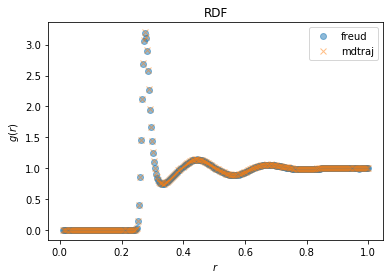

In [4]:
fig, ax = plt.subplots()
ax.plot(freud_rdf.bin_centers, freud_rdf.rdf, 'o', label='freud', alpha=0.5)
ax.plot(*mdtraj_rdf, 'x', label='mdtraj', alpha=0.5)
ax.set_xlabel('$r$')
ax.set_ylabel('$g(r)$')
ax.set_title('RDF')
ax.legend()